In [1]:
import os
import pickle
from pathlib import Path
from collections import defaultdict
from functools import reduce
import yaml
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [125]:
IGNORE = [".__start", ".__end", ".__journal", ".__crash", ".__leaf"]


def get_file_paths(results_path):
    """Returns a list of lists, each containing
    the results file_paths of a trial."""
    file_paths = defaultdict(list)
    for root, dirs, files in os.walk(results_path):
        if ".__end" in files:
            for file in files:
                if file not in IGNORE:
                    file_paths[Path(root)].append(file)
    return file_paths


def load_cfg(yaml_path):
    with open(yaml_path, 'r') as stream:
        return yaml.safe_load(stream)


def load_pkl(pkl_path):
    with open(pkl_path, 'rb') as stream:
        return pickle.load(stream)


def get_config_val(cfg, key):
    """For composed keys."""
    keys = key.split(".")
    return reduce(lambda c, k: c.get(k, {}), keys, cfg)


def get_data(trials, cfg_keys, pkl_metrics, index_key="step", trial_key="run_id", log="train", cb=None):
    print(f"Processing {len(trials)} trials.")
    dataframes = []
    for i, (root_path, files) in enumerate(trials.items()):
        cfg = load_cfg(root_path/"cfg.yaml")
        pkl_file_name = [f for f in files if f'{log}.pkl' in f][0]
        pkl = load_pkl(root_path/pkl_file_name)
        
        # the columns of the dataframe: [index_key] + cfg_keys + pkl_metrics
        data_dict = {index_key: [ev[index_key] for ev in pkl[pkl_metrics[0]]]}
        data_dict.update(
            {k: [ev["value"] for ev in pkl[k]] for k in pkl_metrics}
        )
        data = pd.DataFrame(data_dict)
        # add config values (mostly hyperparams)
        for k in cfg_keys:
            data[k] = get_config_val(cfg, k)
        data["trial"] = cfg[trial_key]
        # additional stuff
        if cb:
            col, val = cb(root_path, cfg, pkl)
            data[col] = val

        dataframes.append(data)          
    return pd.concat(dataframes, ignore_index=True)


# Quick plotting
def plot(df, x="step", y="R/ep", hue=None, style=None, window=10):
    if window:
        new_col = f"avg_{y}"
        group = [c for c in df.columns if c not in ["ep_cnt", "step", x, y]]
        df[new_col] = (df.groupby(group, as_index=False)[y]
                        .rolling(window=window)
                        .mean()
                        .reset_index(0,drop=True))
        print(f"Done rolling average of {y}, grouped by: ", group)
    
    y = f"avg_{y}" if window else y
    hue_key=hue
    if df[hue].dtype not in (str, object):
        print(df[hue].dtype)
        df[f"{hue}_"] = [f"${str(x)}$" for x in df[hue]]
        hue_key = f"{hue}_"
    
    with matplotlib.rc_context({'figure.figsize':(9, 5)}):
        sns.lineplot(x=x, y=y, hue=hue_key, style=style, data=df)

def fix_hue_(data, hue):
    # fix the hue
    hue_key=hue
    if data[hue].dtype not in (str, object):
        print(data[hue].dtype)
        data[f"{hue}_"] = [f"${str(x)}$" for x in df[hue]]
        hue_key = f"{hue}_"
    return hue_key

def plot_grid(data, x="ep_cnt", y="R/ep", rows=None, cols=None,
              hue=None, style=None, window=10):
    # smooth the curves
    if window:
        new_col = f"avg_{y}"
        group = [c for c in data.columns if c not in ["ep_cnt", "step", x, y]]
        data[new_col] = (data.groupby(group, as_index=False)[y]
                        .rolling(window=window)
                        .mean()
                        .reset_index(0,drop=True))
        print(f"Done rolling average of {y}, grouped by: ", group)
    
    y = f"avg_{y}" if window else y
    
    # make subplots
    row_vals = data[rows].unique() if rows else []
    col_vals = data[cols].unique() if cols else []
    nrows = len(row_vals) if rows else 1
    ncols = len(col_vals) if cols else 1
    base_wh, base_hw = 8, 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(base_wh * ncols, base_hw * nrows))
    fig.subplots_adjust(hspace=0.3)
    
    cnt = 0
    if rows:
        for ri, row_val in enumerate(row_vals):
            for ci, col_val in enumerate(col_vals):
                df = data.loc[(data[cols] == col_val) & (data[rows] == row_val)].copy()
                
                hue_key = fix_hue_(df, hue)
                hue_order = sorted(list(df[hue_key].unique()))
                
                ax = axes.flatten()[cnt]
                sns.lineplot(x=x, y=y, hue=hue_key, style=style, data=df, hue_order=hue_order, ax=ax)
                ax.set(title=f"{cols}={col_val}, {rows}={row_val}")
                cnt += 1
    else:
        for ci, col_val in enumerate(col_vals):
            df = data.loc[(data[cols] == col_val)].copy()
            
            hue_key = fix_hue_(df, hue)
            hue_order = sorted(list(df[hue_key].unique()))
            
            ax = axes.flatten()[cnt]
            sns.lineplot(x=x, y=y, hue=hue_key, style=style, hue_order=hue_order, data=df, ax=ax)
            ax.set(title=f"{cols}={col_val}")
            cnt += 1 

## Baseline confirmation

In [132]:
def custom_experiment_name(root_path, cfg, pkl):
    #print(root_path, cfg["experiment"])
    exp_hash = Path(root_path).parts[-2].split('_')[2]
    return "experiment", f"{cfg['experiment']}_{exp_hash}"

In [133]:
experiment_path = "../results/2019Nov26-201531_a2c_confirm/"
hyperparams = ["nsteps", "gamma", "lr", "beta_entropy", "env_name"]
metrics = ["R/ep"]

trial_paths = get_file_paths(experiment_path)
data = get_data(trial_paths, hyperparams, metrics, log="valid", cb=custom_experiment_name)

Processing 55 trials.


In [134]:
data["experiment"].unique()

array(['a2c_ab_7d018958', 'a2c_ab_af32a06a', 'a2c_ab_7c1a7aae',
       'a2c_llc_b5cf56c4', 'a2c_llc_6912ec4c', 'a2c_llc_6ead0806'],
      dtype=object)

### LunarLanderContinous-v2

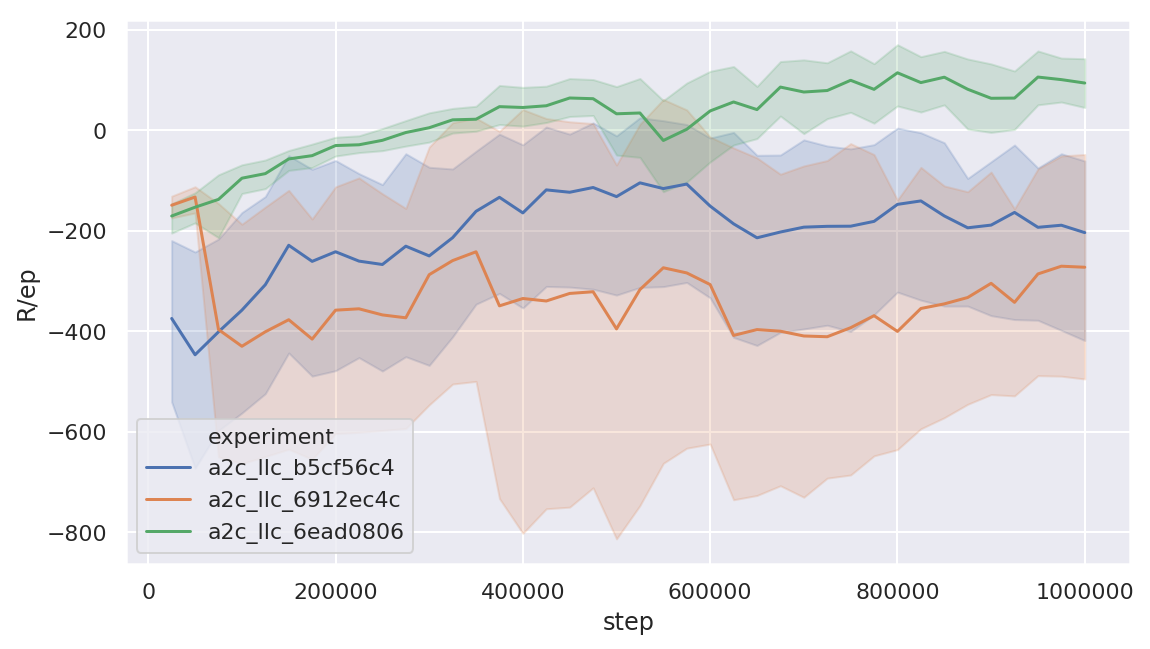

In [135]:
df_llc = data.loc[data["experiment"].isin(['a2c_llc_b5cf56c4', 'a2c_llc_6912ec4c', 'a2c_llc_6ead0806'])].copy()
plot(df_llc, x="step", hue="experiment", window=0)

### Acrobot-v1

Done rolling average of R/ep, grouped by:  ['nsteps', 'gamma', 'lr', 'beta_entropy', 'env_name', 'trial', 'experiment']


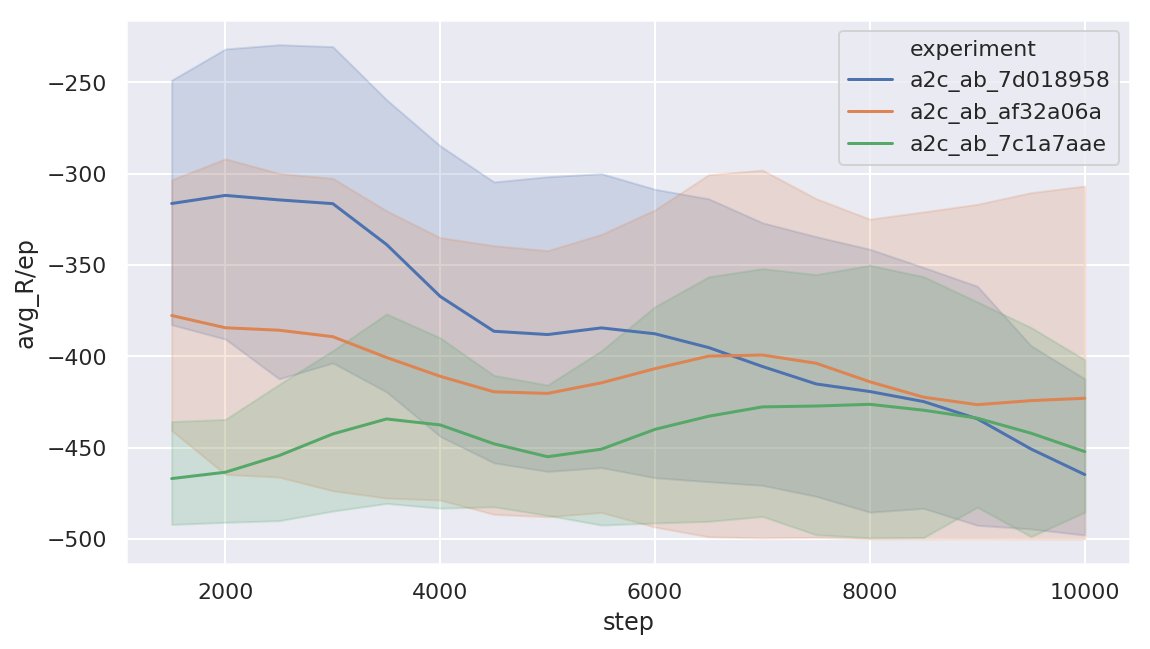

In [136]:
df_ab = data.loc[data["experiment"].isin(['a2c_ab_7d018958', 'a2c_ab_af32a06a', 'a2c_ab_7c1a7aae'])].copy()
plot(df_ab, x="step", hue="experiment", window=3)

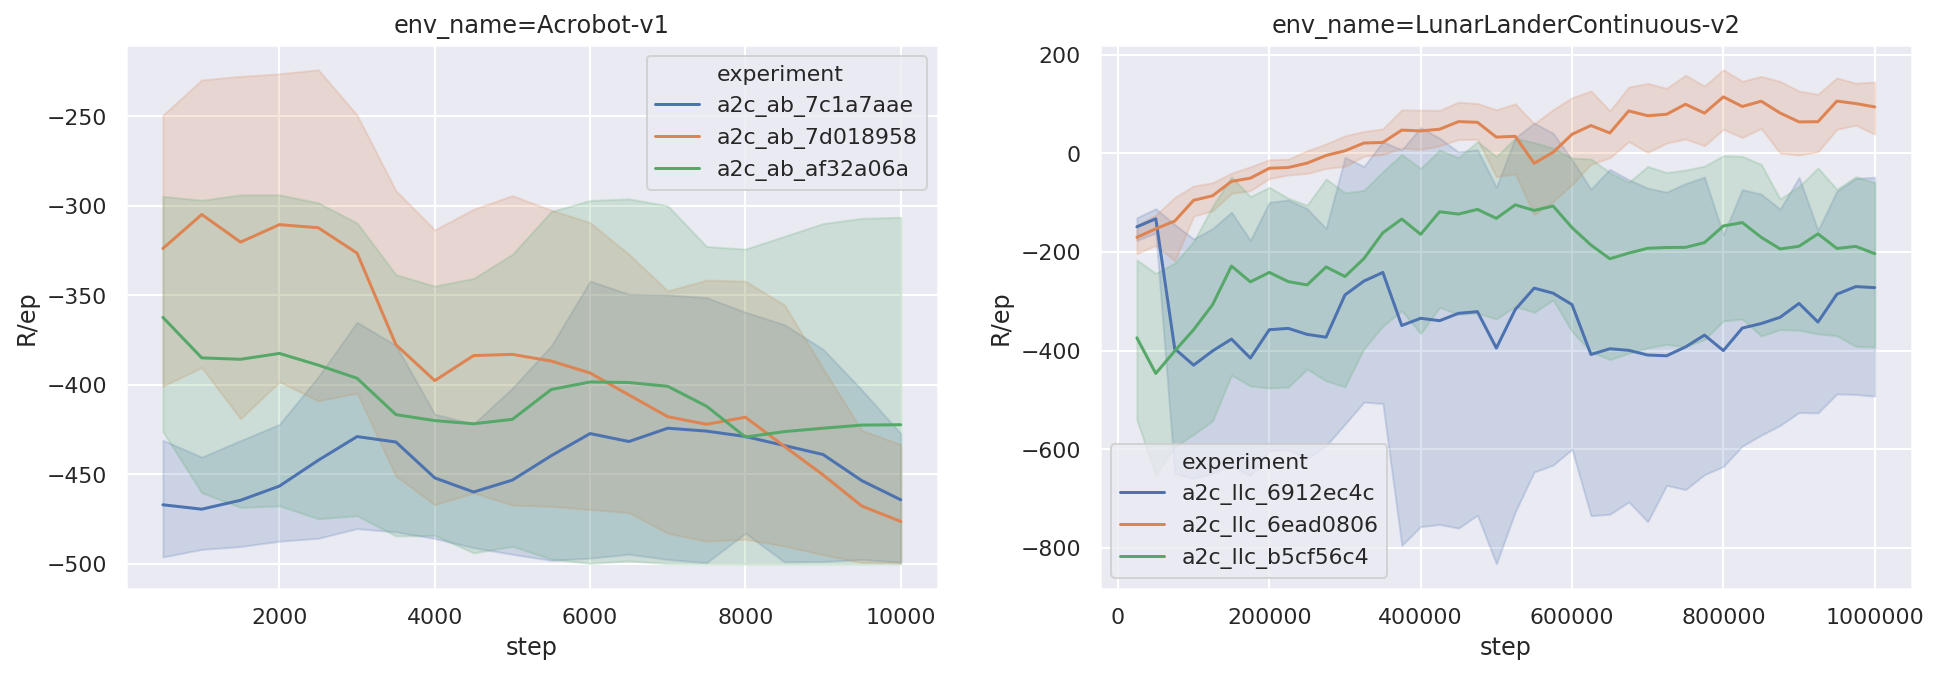

In [137]:
plot_grid(data.copy(), x="step", hue="experiment", cols="env_name", window=0)

## neAC confirmation

In [142]:
experiment_path = "../results/2019Nov27-073328_neac_confirm/"
hyperparams = ["nsteps", "gamma", "lr", "beta_entropy", "dnd.lr", "dnd.size", "dnd.key_size", "env_name"]
metrics = ["R/ep"]

trial_paths = get_file_paths(experiment_path)
data = get_data(trial_paths, hyperparams, metrics, log="valid", cb=custom_experiment_name)

Processing 23 trials.


In [143]:
data.experiment.unique()

array(['neac_llc_97306f06', 'neac_ab_aa315a12', 'neac_ab_1a3ed1d8',
       'neac_llc_4dc127e8'], dtype=object)

### Acrobot-v1

Done rolling average of R/ep, grouped by:  ['nsteps', 'gamma', 'lr', 'beta_entropy', 'dnd.lr', 'dnd.size', 'dnd.key_size', 'env_name', 'trial', 'experiment']


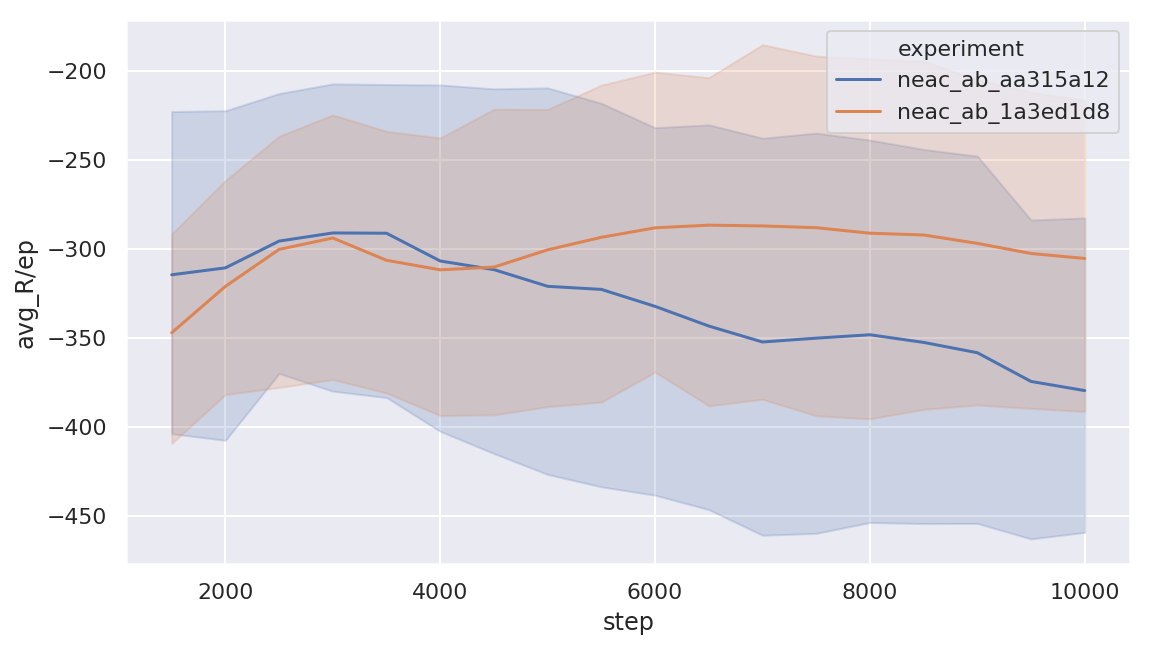

In [144]:
df_ab = data.loc[data["experiment"].isin(['neac_ab_aa315a12', 'neac_ab_1a3ed1d8'])].copy()
plot(df_ab, x="step", hue="experiment", window=3)

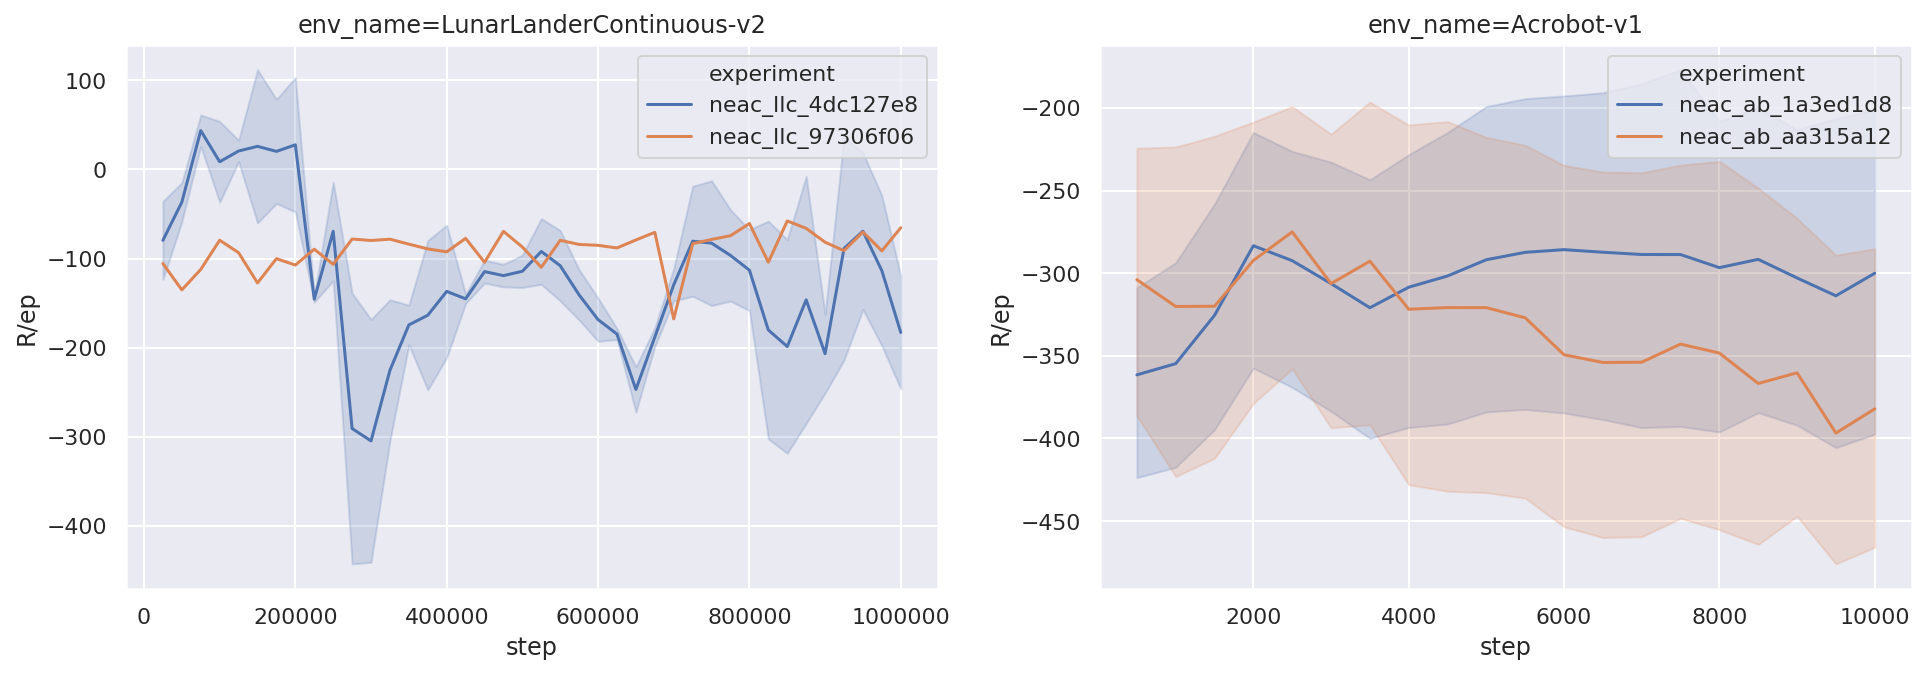

In [145]:
plot_grid(data.copy(), x="step", hue="experiment", cols="env_name", window=0)